In [1]:
# fetch the dataset
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0.json
!unzip -q maestro-v3.0.0-midi.zip

--2022-05-11 07:44:42--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58416533 (56M) [application/octet-stream]
Saving to: ‘maestro-v3.0.0-midi.zip’

maestro-v3.0.0-midi 100%[===================>]  55.71M   111MB/s    in 0.5s    

2022-05-11 07:44:43 (111 MB/s) - ‘maestro-v3.0.0-midi.zip’ saved [58416533/58416533]

--2022-05-11 07:44:43--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.211.128, 173.194.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 

In [2]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle

from torch.utils.data import Dataset, DataLoader
from os import path

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
BASE_PATH = "/content"
DATASET_PATH = "maestro-v3.0.0"

with open("maestro-v3.0.0.json", "r") as index:
  index_js = json.load(index)

def get_path(index: int) -> str:
  return path.join(BASE_PATH, DATASET_PATH, index_js["midi_filename"][str(index)])

def tics_to_millis(tempo: int, ticks_per_beat: int, ticks: int) -> int:
  return int(round(tempo * ticks / (ticks_per_beat * 10000)))

In [5]:
MAX_POWER = 10 # pre-computed in previous tokenization

In [6]:
# import serializer definition
%run /content/gdrive/MyDrive/Colab\ Notebooks/serializer-chord.ipynb

     |████████████████████████████████| 51 kB 3.0 MB/s 


In [7]:
serializer = Serializer(MAX_POWER)

In [8]:
# create datasets
train = []
test = []
validation = []
lens = []

for id in index_js["midi_filename"].keys():
  if int(id) % 100 == 0:
    print(id)

  midi = MidiFile(get_path(int(id)))
  split = index_js["split"][id]
  tokenized = serializer.tokenize(midi)
  lens.extend([len(piece) for piece in tokenized])

  if split == "train":
    train.extend(tokenized)
  elif split == "test":
    test.extend(tokenized)
  elif split == "validation":
    validation.extend(tokenized)
  else:
    raise Exception("Unexpected split value: \"{}\"".format(split))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200


Text(0.5, 1.0, 'Max tokens per example: 81888')

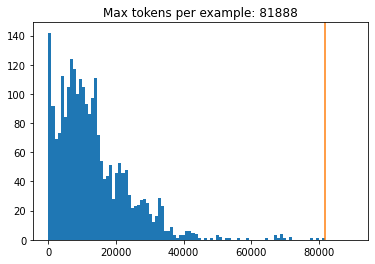

In [9]:
max_len = max(lens)
plt.hist(lens, np.linspace(0, int(max_len * 1.1), 101))
plt.ylim(plt.ylim())
plt.plot([max_len, max_len], plt.ylim())
plt.title(f'Max tokens per example: {max_len}')

In [10]:
MAX_TOKENS = max_len
DS_PATH = '/content/gdrive/MyDrive/BP/datasets/MAESTRO-chord'

In [11]:
def store_lists(dataset_split: list, relative_path: str, size=MAX_TOKENS):
  for i, example in enumerate(dataset_split):
    if len(example) > size:
      example = example[:size]
      example[-1] = SpecialTokens.END.value
    elif len(example) < size:
      example.extend([SpecialTokens.PADDING.value] * (size - len(example)))
    final_path = path.join(DS_PATH, relative_path, str(i) + ".pt")
    torch.save(torch.tensor(example, dtype=torch.int64), final_path)

In [12]:
store_lists(train, "train", 4097)
store_lists(test, "test", 4097)
store_lists(validation, "validation", 4097)

In [13]:
with open(path.join(DS_PATH, 'serializer.pickle'), 'wb') as f:
  pickle.dump(serializer, f)

In [17]:
id = 1000
mid = MidiFile(get_path(id))
serialized = serializer.tokenize(mid)[0][:2048]
deserialized = serializer.deserialize(serialized)
deserialized.save('/content/deser.midi')